# PINN

La idea de este proyecto es implementar una red neuronal informada por la física (PINN) que se ajuste a la ecuación diferencial
$$
\begin{cases}
    -\Delta u + \alpha u = f, & x \in (0,π)\\
    u = g, & x \in \{0,π\}
\end{cases}
$$
donde  f  y  g  son funciones dadas.

## Preparación

Lo primero que debemos hacer es instalar e importar las librerías necesarias.

In [28]:
pip install keras-core

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Tomás\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import pandas as pd
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras_core as keras

Como necesitamos precisión se establece una semilla aleatoria en Keras, lo que garantiza que las operaciones aleatorias sean reproducibles. Esto significa que cada vez que se ejecute el código, las operaciones aleatorias producirán los mismos resultados, lo que facilita la depuración y la comparación de diferentes ejecuciones del modelo.

In [30]:
keras.utils.set_random_seed(1234)

Ahora se configura Keras para utilizar float64 como el tipo de datos predeterminado para todas las operaciones de punto flotante. Esto asegura que todas las capas y operaciones en el modelo utilicen la precisión doble, lo que puede ser necesario para ciertos problemas que requieren una mayor precisión numérica.

In [31]:
dtype='float64'
keras.backend.set_floatx(dtype)

Definamos de una vez los parámetros específicos del problema

In [32]:
alpha = 1
limInf= 0
limSup = np.pi

Se definen también los parámetros para las redes de ambos planteamientos.

In [33]:
# Número de neuronas por capa oculta en la red neuronal
neurons = 10
# Número de capas ocultas
nLayers = 4
# Número de puntos de integración
nPts = 1000
# Número de iteraciones de entrenamiento
iterations = 1000

# Factores de peso para las condiciones de frontera (planteamiento 1)
lambda0 = 2
lambda1 = 5
lambda2 = 8

## Planteamiento 1

El  primer  planteamiento  utiliza  la  función  de  pérdida  de  mínimos  cuadrados, incluyendo  las condiciones de frontera directamente en la función de pérdida. Esto significa que la función de pérdida calcula tanto el error de la ecuación diferencial parcial (PDE) como el error de las condiciones de frontera.

$$
\mathcal{L}(u_{NN}) = \frac{1}{N} \sum_{i=1}^{N} \left( -\Delta u_{NN}(x_i) + \alpha u_{NN}(x_i) - f(x_i) \right)^2
+ \lambda_1 \left( u_{NN}(0) - g(0) \right)^2
+ \lambda_2 \left( u_{NN}(1) - g(1) \right)^2
$$

En donde $\lambda_1$ y $\lambda_2$ son parámetros.

Creamos una función que contenga el modelo de red neuronal utilizando Keras para aproximar la solución de una ecuación diferencial parcial (EDP):

In [34]:
def makeModel1(neurons, nLayers, activation):
    """
    Crea un modelo de red neuronal para aproximar la solución de la EDP.

    Args:
        neurons (int): Número de neuronas en cada capa oculta.
        nLayers (int): Número de capas ocultas.
        activation (str, opcional): Función de activación para las capas ocultas.

    Returns:
        keras.Model: Un modelo de red neuronal para la solución aproximada.
    """

    # Input layer
    xVals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)

    # Hidden layer
    l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(xVals)
    for l in range(nLayers - 2):
        l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(l1)

    # Output layer
    output = keras.layers.Dense(1, activation=activation, dtype=dtype)(l1)

    uModel = keras.Model(inputs=xVals, outputs=output, name='u_model')

    return uModel

Veamos los detalles de este modelo:

In [35]:
uModel1 = makeModel1(neurons=neurons, nLayers=nLayers, activation='tanh')

# Imprimir la información del modelo u
uModel1.summary()

Model: "u_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ x_input (InputLayer)            │ (None, 1)                 │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_36 (Dense)                │ (None, 10)                │         20 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_37 (Dense)                │ (None, 10)                │        110 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_38 (Dense)                │ (None, 10)                │        110 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_39 (Dense)                │ (None, 1)                 │         11 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 251 (1.96 KB)

 Trainable params: 251 (1.96 KB)

 Non-trainable params: 0 (0.00 B)

Sigue definir una capa personalizada en Keras que calcule la pérdida para las Redes Neuronales Informadas por Física (PINNs).

In [36]:
class Loss1(keras.layers.Layer):
    def __init__(self, uModel, nPts, f, lambda0 = 1,lambda1=1, lambda2=1, limInf=0, limSup=np.pi, **kwargs):
        """
        Inicializa la capa de pérdida de PINNs con los parámetros proporcionados.

        Args:
            u_model (keras.Model): El modelo de red neuronal para la solución aproximada.
            n_pts (int): Número de puntos de integración.
            f (función): Fuente - RHS de la PDE
            lambda0 (float): Factor de peso para la ecuación diferencial parcial (PDE)
            lambda1 (float): Factor de peso para la condición de frontera 1.
            lambda2 (float): Factor de peso para la condición de frontera 2.
            limInf (float): Límite inferior del dominio.
            limSup (float): Límite superior del dominio.

            kwargs: Argumentos adicionales.
        """
        super(Loss1, self).__init__()
        self.uModel = uModel
        self.nPts = nPts
        self.f = f
        self.lambda0 = lambda0
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.limInf = limInf
        self.limSup = limSup

    def call(self, inputs):
        """
        Calcula la pérdida de colación - PINNs.

        Args:
            inputs: Los datos de entrada (dummy).

        Returns:
            keras.Tensor: El valor de la pérdida.
        """
        # Generar puntos de integración aleatorios
        x = tf.random.uniform([self.nPts], self.limInf, self.limSup, dtype=dtype)

        # Tomar gradientes (parte basada en tf)
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(x)
            with tf.GradientTape(persistent=True) as t2:
                t2.watch(x)
                u = self.uModel(x, training=True)
            dux = t2.gradient(u, x)
        duxx = t1.gradient(dux, x)

        # Pérdida de PDE
        errorPDE = self.lambda0*keras.ops.mean((-duxx + alpha * u - self.f(x)) ** 2)

        # Pérdida de BC de Dirichlet
        bc = self.lambda1 * self.uModel(np.array([self.limInf])) ** 2 + self.lambda2 * self.uModel(np.array([self.limSup])) ** 2
        return errorPDE + bc

Definimos la función makeLossModel. El propósito de esta función es construir un modelo de pérdida que se puede utilizar para entrenar la PINN. Este modelo de pérdida calcula el error de la solución aproximada de la PDE utilizando puntos de integración aleatorios y la función de pérdida definida en la clase Loss.

In [37]:
def makeLossModel1(uModel, nPts, f,lambda0=1, lambda1=1, lambda2=1, limInf=0, limSup=np.pi):
    """
    Construye un modelo de pérdida para PINNs.

    Args:
        uModel (keras.Model): El modelo de red neuronal para la solución aproximada.
        nPts (int): Número de puntos de integración.
        f (función): Fuente - RHS de la PDE
        lambda0 (float): Factor de peso para la ecuación diferencial parcial (PDE)
        lambda1 (float): Factor de peso para la condición de frontera 1.
        lambda2 (float): Factor de peso para la condición de frontera 2.
        limInf (float): Límite inferior del dominio.
        limSup (float): Límite superior del dominio.

    Returns:
        keras.Model: Un modelo con la función de pérdida basada en colación.
    """
    xVals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)

    # Calcular la pérdida utilizando la red neuronal proporcionada y
    # los parámetros de integración
    output = Loss1(uModel, nPts, f,lambda0, lambda1, lambda2, limInf, limSup)(xVals)

    # Crear un modelo de Keras para la pérdida
    lossModel = keras.Model(inputs=xVals, outputs=output)

    return lossModel

Definimos la función trickyLoss. El propósito de esta función es actuar como un marcador de posición para la función de pérdida. En un escenario real, esta función se sustituiría por una función de pérdida personalizada que calcule la diferencia entre los valores predichos (yPred) y los valores verdaderos (yTrue). La función de pérdida es crucial para el entrenamiento de modelos de aprendizaje automático, ya que guía el proceso de optimización ajustando los pesos del modelo para minimizar el error.

In [38]:
def trickyLoss(yPred, yTrue):
    """
    Una función de pérdida de marcador de posición que se puede reemplazar según sea necesario.

    Args:
        yPred: Valores predichos.
        yTrue: Valores verdaderos.

    Returns:
        float: El valor de la pérdida.
    """
    # Esta es una función de pérdida de marcador de posición que se puede sustituir por una
    # pérdida personalizada si es necesario.
    return yTrue

## Planteamiento 2

El  segundo  planteamiento  propone  una  solución  para  el  caso  en  que  la  frontera cumple  $g = 0$, en donde

$$
u_{NN} = NN(x) \cdot x \cdot (x - π)
$$

Con función de pérdida  

$$
\mathcal{L}(u_{NN}) = \frac{1}{N} \sum_{i=1}^{N} \left( -\Delta u_{NN}(x_i) + \alpha u_{NN}(x_i) - f(x_i) \right)^2
$$

Aquí las condiciones de frontera se manejan dentro del modelo de red neuronal en lugar de la función de pérdida. Esto se logra mediante el uso de una capa Lambda que ajusta la salida del modelo para cumplir con las condiciones de frontera.


In [39]:
def makeModel2(neurons, nLayers, activation, limInf=0, limSup=np.pi):
    """
    Crea un modelo de red neuronal para aproximar la solución de la EDP.

    Args:
        neurons (int): Número de neuronas en cada capa oculta.
        nLayers (int): Número de capas ocultas.
        activation (str, opcional): Función de activación para las capas ocultas.
        limInf (float): Límite inferior del dominio.
        limSup (float): Límite superior del dominio.

    Returns:
        keras.Model: Un modelo de red neuronal para la solución aproximada.
    """

    # Input layers
    xVals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)

    # Hidden layers
    l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(xVals)

    for l in range(nLayers - 2):
        l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(l1)

    # Output layers (hasta la penúltima capa)
    output = keras.layers.Dense(1, activation=activation, dtype=dtype)(l1)

    # Layer en donde se pone información de los términos de frontera (capa Lambda).
    boundaryC = keras.layers.Lambda(lambda x: (x-limInf)*(x-limSup))(xVals)

    # También hay que añadir una capa Multiply para manejar las condiciones de frontera.
    # Aqui se multiplica la red de capas densas con los términos que relacionan las condiciones de frontera
    output = keras.layers.Multiply()([output, boundaryC])

    uModel = keras.Model(inputs=xVals, outputs=output, name='u_model')

    return uModel

Veamos los detalles de este modelo:

In [40]:
uModel2 = makeModel2(neurons=neurons, nLayers=nLayers, activation='tanh', limInf=limInf, limSup=limSup)

# Imprimir la información del modelo u
uModel2.summary()

Model: "u_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ x_input             │ (None, 1)         │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_40 (Dense)    │ (None, 10)        │      20 │ x_input[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_41 (Dense)    │ (None, 10)        │     110 │ dense_40[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_42 (Dense)    │ (None, 10)        │     110 │ dense_41[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_43 (Dense)    │ (None, 1)         │      11 │ dense_42[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │       0 │ x_input[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply_1          │ (None, 1)         │       0 │ dense_43[0][0],      │
│ (Multiply)          │                   │         │ lambda_1[0][0]       │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 251 (1.96 KB)

 Trainable params: 251 (1.96 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
class Loss2(keras.layers.Layer):
    def __init__(self, uModel, nPts, f, limInf=0, limSup=np.pi, **kwargs):
        """
        Inicializa la capa de pérdida de PINNs con los parámetros proporcionados.

        Args:
            u_model (keras.Model): El modelo de red neuronal para la solución aproximada.
            n_pts (int): Número de puntos de integración.
            f (función): Fuente - RHS de la PDE
            limInf (float): Límite inferior del dominio.
            limSup (float): Límite superior del dominio.

            kwargs: Argumentos adicionales.
        """
        super(Loss2, self).__init__()
        self.uModel = uModel
        self.nPts = nPts
        self.f = f
        self.limInf = limInf
        self.limSup = limSup


    def call(self, inputs):
        """
        Calcula la pérdida de colación - PINNs.

        Args:
            inputs: Los datos de entrada (dummy).

        Returns:
            keras.Tensor: El valor de la pérdida.
        """
        # Generar puntos de integración aleatorios
        x = tf.random.uniform([self.nPts], dtype=dtype, minval=self.limInf, maxval=self.limSup)

        # Tomar gradientes (parte basada en tf)
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(x)
            with tf.GradientTape(persistent=True) as t2:
                t2.watch(x)
                u = self.uModel(x, training=True)
            dux = t2.gradient(u, x)
        duxx = t1.gradient(dux, x)

        # Pérdida de PDE
        errorPDE = keras.ops.mean((-duxx + alpha * u - self.f(x)) ** 2)

        return errorPDE

In [42]:
def makeLossModel2(uModel, nPts, f, limInf=0, limSup=np.pi):
    """
    Construye un modelo de pérdida para PINNs.

    Args:
        uModel (keras.Model): El modelo de red neuronal para la solución aproximada.
        nPts (int): Número de puntos de integración.
        f (función): Fuente - RHS de la PDE
        limInf (float): Límite inferior del dominio.
        limSup (float): Límite superior del dominio.

    Returns:
        keras.Model: Un modelo con la función de pérdida basada en colación.
    """
    xVals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)

    # Calcular la pérdida utilizando la red neuronal proporcionada y
    # los parámetros de integración
    output = Loss2(uModel, nPts, f, limInf, limSup)(xVals)

    # Crear un modelo de Keras para la pérdida
    lossModel = keras.Model(inputs=xVals, outputs=output)

    return lossModel

No es necesario definir otra función para trickyLoss

## Error Relativo

Ahora necesitamos una buena manera de cuantificar que tan bueno es nuestro modelo, para eso usamos el error relativo:
$$
\frac{\frac{1}{N} \sum (u_{nn}(x) - u(x))^2}{\frac{1}{N} \sum (u(x))^2}
$$
Y lo implementamos en forma de callback.

In [43]:
class RelativeErrorCallback(tf.keras.callbacks.Callback):
    def __init__(self, uModel, exactU, nPts):
        """
        Inicializa el callback con el modelo de red neuronal, la solución exacta y el número de puntos.

        Args:
            uModel (keras.Model): El modelo de red neuronal entrenado.
            exactU (func): Función que representa la solución exacta.
            nPts (int): Número de puntos para la evaluación.
        """
        super().__init__()
        self.uModel = uModel
        self.exactU = exactU
        self.nPts = nPts

    def on_epoch_end(self, epoch, logs=None):
        """
        Calcula el error relativo al final de cada época de entrenamiento.

        Args:
            epoch (int): El número de la época actual.
            logs (dict, opcional): Diccionario de registros de métricas.
        """
        # Generar una lista de valores x para la evaluación
        Sval = tf.experimental.numpy.linspace(0., np.pi, num=self.nPts * 10, dtype=dtype)
        
        # Calcular las derivadas de la solución aproximada y la solución exacta
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(Sval)
            ueval_val = self.uModel(Sval)
            u_x_val = t1.gradient(ueval_val, Sval)
            u_e = self.exactU(Sval)
            ue_x = t1.gradient(u_e, Sval)
        
        # Eliminar el GradientTape para liberar memoria
        del t1
        
        # Calcular el error H01 entre la derivada de la solución exacta y la derivada de la solución aproximada
        errorH01 = tf.reduce_mean((ue_x - u_x_val) ** 2)
        
        # Calcular la norma de la derivada de la solución exacta
        norm_exact = tf.reduce_mean(ue_x ** 2)
        
        # Calcular el error relativo
        relative_error = errorH01 / norm_exact
        
        # Guardar el error relativo en los registros de métricas
        logs['relative_error'] = relative_error

## Ejemplos

Primero definimos la función f (RHS), que es el término fuente en el lado derecho de la ecuación diferencial parcial (PDE) que se está resolviendo con la red neuronal informada por física (PINN).

In [44]:
# PDE RHS
def fRhs(x):
    return (alpha - 4) * keras.ops.sin(2 * x)

# Definir la solución exacta
def exactU(x):
    return keras.ops.sin(2 * x)

Y hacemos una función para graficar los resultados.

In [45]:
def plotResults(uModel, history, exactU, xList):
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 18
    rcParams['legend.fontsize'] = 17
    rcParams['mathtext.fontset'] = 'cm'
    rcParams['axes.labelsize'] = 19

    fig, ax = plt.subplots()
    plt.plot(xList, uModel(xList), color='b')
    plt.plot(xList, exactU(xList), color='m')
    plt.legend(['u_approx', 'u_exact'])
    ax.grid(which='both', axis='both', linestyle=':', color='gray')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    plt.plot(history.history['loss'], color='r')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.legend(['loss'])
    ax.grid(which='major', axis='both', linestyle=':', color='gray')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    plt.plot(history.history['relative_error'], color='b')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.legend(['Relative Error'])
    ax.grid(which='major', axis='both', linestyle=':', color='gray')
    plt.tight_layout()
    plt.show()

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(history.history['loss'], 'g-')
    ax2.plot(history.history['relative_error'], 'b-')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='g')
    ax2.set_ylabel('Relative Error', color='b')
    plt.legend(['Loss', 'Relative Error'])
    plt.tight_layout()
    plt.show()

### Ej. planteamiento 1

Ahora entrenamos los modelos.

In [46]:
# Gran modelo incluyendo la pérdida
lossModel1 = makeLossModel1(uModel1, nPts, fRhs, lambda0, lambda1, lambda2, limInf, limSup)

# Optimizador (optimizador Adam con una tasa de aprendizaje específica)
optimizer = keras.optimizers.Adam(learning_rate=10**-3)

# Compilar el modelo de pérdida con una función de pérdida personalizada (trickyLoss)
lossModel1.compile(optimizer=optimizer, loss=trickyLoss)

# Entrenar el modelo utilizando un único punto de datos de entrenamiento ([1.], [1.]) para un
# número especificado de épocas (iteraciones)
relative_error_callback = RelativeErrorCallback(uModel1, exactU, nPts)
history1 = lossModel1.fit(np.array([1.]), np.array([1.]), epochs=iterations, verbose=1, callbacks=[relative_error_callback])

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 9.0767 - relative_error: 1.0054
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 8.4103 - relative_error: 1.0107
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 8.7751 - relative_error: 1.0162
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 8.6628 - relative_error: 1.0217
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 8.5113 - relative_error: 1.0269
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 8.8631 - relative_error: 1.0316
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.8891 - relative_error: 1.0362
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 8.4852 - relative_error: 1.0406
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 8.7574 - relative_error: 1.0448
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 8.4060 - relative_error: 1.0490
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 8.6153 - relative_error: 1.0532

Y graficamos los resultados

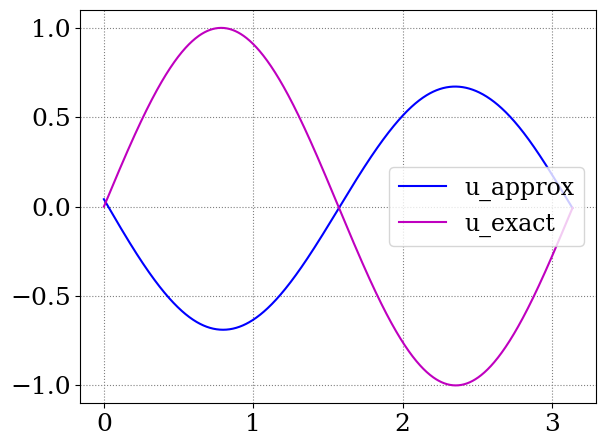

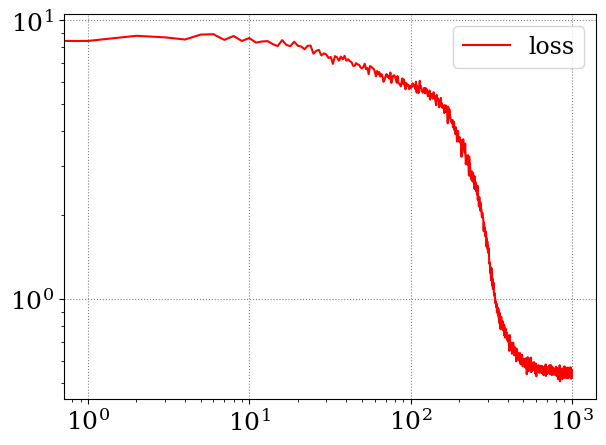

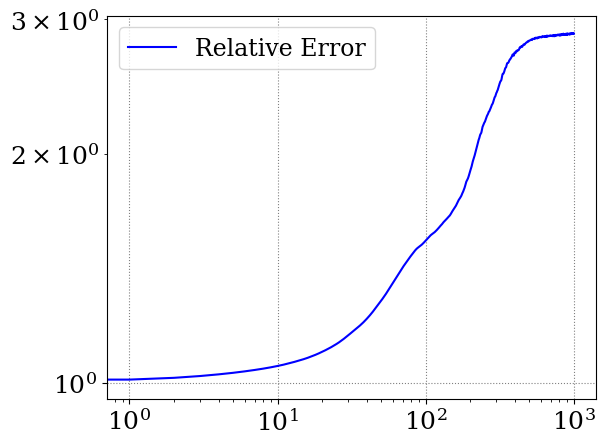

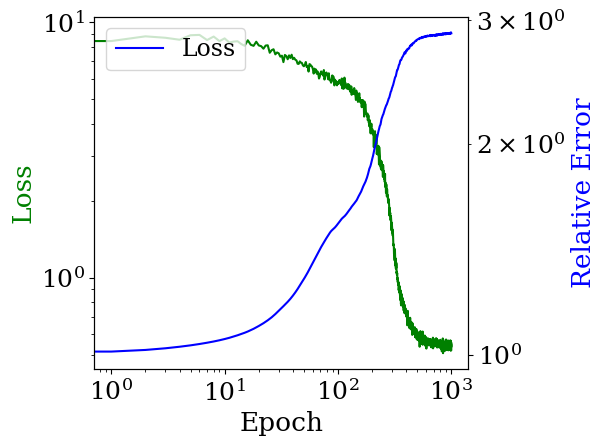

In [47]:
# Generar una lista de valores x para la visualización
xList = np.array([np.pi / 1000 * i for i in range(1000)])

# Llamar a la función para graficar los resultados
plotResults(uModel1, history1, exactU, xList)

### Ej. planteamiento 2

Entrenamos el modelo

In [48]:
# Gran modelo incluyendo la pérdida
lossModel2 = makeLossModel2(uModel2, nPts, fRhs)

# Optimizador (optimizador Adam con una tasa de aprendizaje específica)
optimizer2 = keras.optimizers.Adam(learning_rate=10**-3)

# Compilar el modelo de pérdida con una función de pérdida personalizada (trickyLoss)
lossModel2.compile(optimizer=optimizer2, loss=trickyLoss)

# Entrenar el modelo utilizando un único punto de datos de entrenamiento ([1.], [1.]) para un
# número especificado de épocas (iteraciones)
relative_error_callback = RelativeErrorCallback(uModel2, exactU, nPts)
history2 = lossModel2.fit(np.array([1.]), np.array([1.]), epochs=iterations, verbose=0, callbacks=[relative_error_callback])

Graficamos los resultados

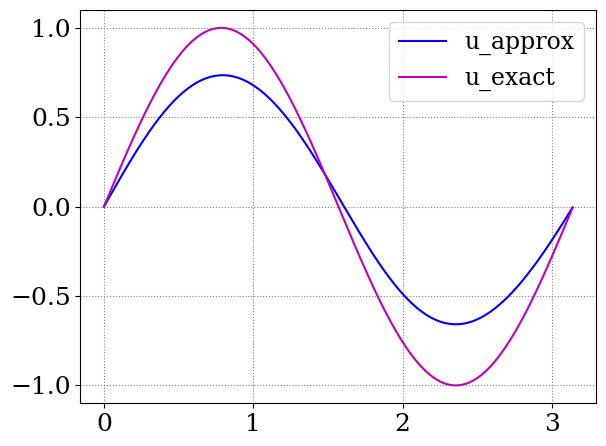

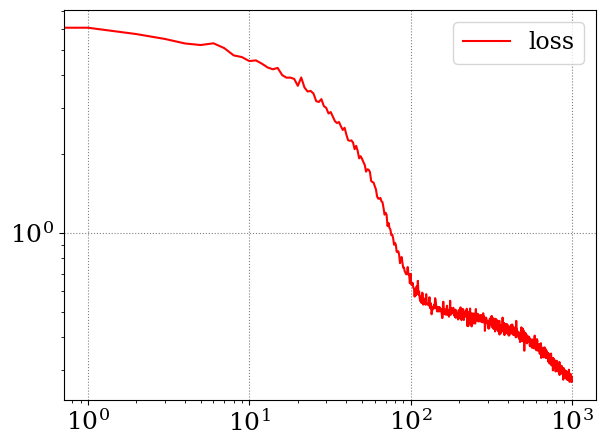

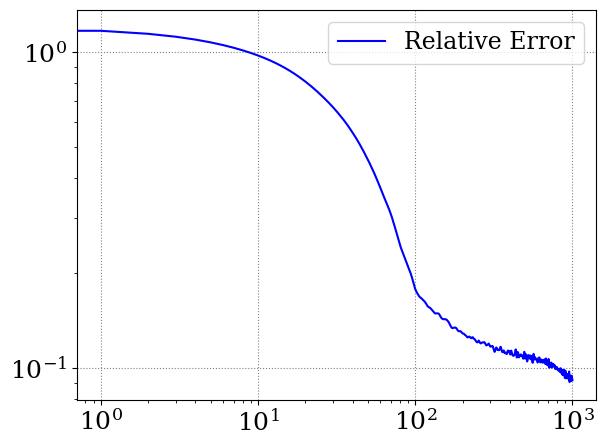

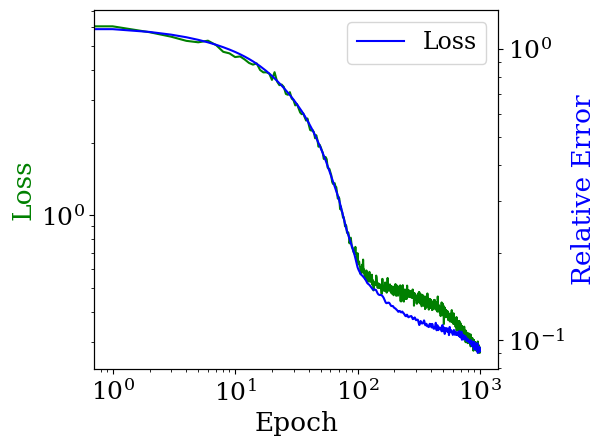

In [49]:
# Definir la solución exacta
def exactU(x):
    return keras.ops.sin(2 * x)

# Generar una lista de valores x para la visualización
xList = np.array([np.pi / 1000 * i for i in range(1000)])

plotResults(uModel2, history2, exactU, xList)

## Función de Funciones

Queremos probar como funcionan las redes neuronales con otras funciones, en concreto vamos a probar con: 

1. $ u(x) = \sin(2x) $

2. $ u(x) = \sin(2x) \cos\left(\frac{x}{2}\right) $

3. $ u(x) = x^2 (x - \pi)^2 $

4. $ u(x) = x^3 - 3x^2 + 2x $

5. $ u(x) = e^x $

6. $ u(x) = \sinh(x) $

7. $ u(x) = \frac{1}{1 + x^2} $

Primero vamos a hacer código para graficar los resultados

In [50]:
def plotResultsGrid(uModel, history, exactU, xList, title, ax):
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 18
    rcParams['legend.fontsize'] = 17
    rcParams['mathtext.fontset'] = 'cm'
    rcParams['axes.labelsize'] = 19

    # Plot u vs u_approx
    ax[0].plot(xList, uModel(xList), color='b')
    ax[0].plot(xList, exactU(xList), color='m')
    ax[0].legend(['u_approx', 'u_exact'])
    ax[0].grid(which='both', axis='both', linestyle=':', color='gray')
    ax[0].set_title(title)

    # Plot loss
    ax[1].plot(history.history['loss'], color='r')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].legend(['loss'])
    ax[1].grid(which='major', axis='both', linestyle=':', color='gray')

    # Plot relative error
    ax[2].plot(history.history['relative_error'], color='b')
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    ax[2].legend(['Relative Error'])
    ax[2].grid(which='major', axis='both', linestyle=':', color='gray')

    # Plot loss vs relative error
    ax1 = ax[3]
    ax2 = ax1.twinx()
    ax1.plot(history.history['loss'], 'g-')
    ax2.plot(history.history['relative_error'], 'b-')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='g')
    ax2.set_ylabel('Relative Error', color='b')
    ax1.legend(['Loss'], loc='upper left')
    ax2.legend(['Relative Error'], loc='upper right')
    ax1.grid(which='major', axis='both', linestyle=':', color='gray')

Ahora hagamos el código para correr las funciones. Usaremos una función llamada run_experiments_with_different_fRhs(), que recibe como argumento el planteamiento que se desea usar (1 o 2) y la función de activación.

In [54]:
def run_experiments_with_different_fRhs(planteamiento, activation_function):
    functions = [
        {
            'fRhs': lambda x: (alpha + 4) * keras.ops.sin(2 * x),
            'exactU': lambda x: keras.ops.sin(2 * x),
            'title': 'sin(2x)'
        },
        {
            'fRhs': lambda x: 17/4 * keras.ops.sin(2 * x) * keras.ops.cos(x / 2) + 2 * keras.ops.sin(x / 2) * keras.ops.cos(2 * x) + alpha * keras.ops.sin(2 * x) * keras.ops.cos(x / 2),
            'exactU': lambda x: keras.ops.sin(2 * x) * keras.ops.cos(x / 2),
            'title': 'sin(2x) * cos(x/2)'
        },
        {
            'fRhs': lambda x: - 2 * (6 * x**2 - 6 * np.pi * x + np.pi**2) + alpha * (x**2 * (x - np.pi)**2),
            'exactU': lambda x: x**2 * (x - np.pi)**2,
            'title': 'x^2 * (x - pi)^2'
        },
        {
            'fRhs': lambda x: - 6 * (x - 1) + alpha * (x**3 - 3*x**2 + 2*x),
            'exactU': lambda x: x**3 - 3*x**2 + 2*x,
            'title': 'x^3 - 3x^2 + 2x'
        },
        {
            'fRhs': lambda x: - keras.ops.exp(x) + alpha * keras.ops.exp(x),
            'exactU': lambda x: keras.ops.exp(x),
            'title': 'exp(x)'
        },
        {
            'fRhs': lambda x: - keras.ops.sinh(x) + alpha * keras.ops.sinh(x),
            'exactU': lambda x: keras.ops.sinh(x),
            'title': 'sinh(x)'
        },
        {
            'fRhs': lambda x: - ( ( (8 * x**2) / (1 + x**2)**3 ) - ( 2 / (1 + x**2)**2 ) ) + alpha * 1 / (1 + x**2),
            'exactU': lambda x: 1 / (1 + x**2),
            'title': '1 / (1 + x^2)'
        },
    ]

    results = []

    fig, axs = plt.subplots(len(functions), 4, figsize=(20, 5 * len(functions)))

    for i, func in enumerate(functions):
        fRhs = func['fRhs']
        exactU = func['exactU']
        title = func['title']

        if planteamiento == 1:

            uModel1 = makeModel1(neurons=neurons, nLayers=nLayers, activation=activation_function)
            lossModel1 = makeLossModel1(uModel1, nPts, fRhs, lambda0, lambda1, lambda2, limInf, limSup)
            optimizer = keras.optimizers.Adam(learning_rate=10**-3)
            lossModel1.compile(optimizer=optimizer, loss=trickyLoss)

            relative_error_callback = RelativeErrorCallback(uModel1, exactU, nPts)
            history1 = lossModel1.fit(np.array([1.]), np.array([1.]), epochs=iterations, verbose=0, callbacks=[relative_error_callback])
            
            final_loss = history1.history['loss'][-1]
            final_relative_error = history1.history['relative_error'][-1].numpy()  # Convert tensor to numpy
            results.append({
                'title': title,
                'final_loss': final_loss,
                'final_relative_error': final_relative_error,
            })

            xList = np.array([np.pi / 1000 * i for i in range(1000)])
            plotResultsGrid(uModel1, history1, exactU, xList, title, axs[i])

        elif planteamiento == 2:
            uModel2 = makeModel2(neurons=neurons, nLayers=nLayers, activation=activation_function)
            lossModel2 = makeLossModel2(uModel2, nPts, fRhs, limInf, limSup)
            optimizer = keras.optimizers.Adam(learning_rate=10**-3)
            lossModel2.compile(optimizer=optimizer, loss=trickyLoss)

            relative_error_callback = RelativeErrorCallback(uModel2, exactU, nPts)
            history2 = lossModel2.fit(np.array([1.]), np.array([1.]), epochs=iterations, verbose=0, callbacks=[relative_error_callback])

            final_loss = history2.history['loss'][-1]
            final_relative_error = history2.history['relative_error'][-1].numpy()

            results.append({
                'title': title,
                'final_loss': final_loss,
                'final_relative_error': final_relative_error
            })

            xList = np.array([np.pi / 1000 * i for i in range(1000)])
            plotResultsGrid(uModel2, history2, exactU, xList, title, axs[i])

    df_results = pd.DataFrame(results)
    print(df_results.to_string(index=False))  # Print DataFrame without index
    plt.tight_layout()
    plt.show()

             title  final_loss  final_relative_error
           sin(2x)    3.394493              0.016053
sin(2x) * cos(x/2)    0.990703              0.024222
  x^2 * (x - pi)^2  210.500527              0.724318
   x^3 - 3x^2 + 2x   15.969900              0.715816
            exp(x)    0.000278              0.999347
           sinh(x)    0.000002              1.000000
     1 / (1 + x^2)    0.012543              1.290998


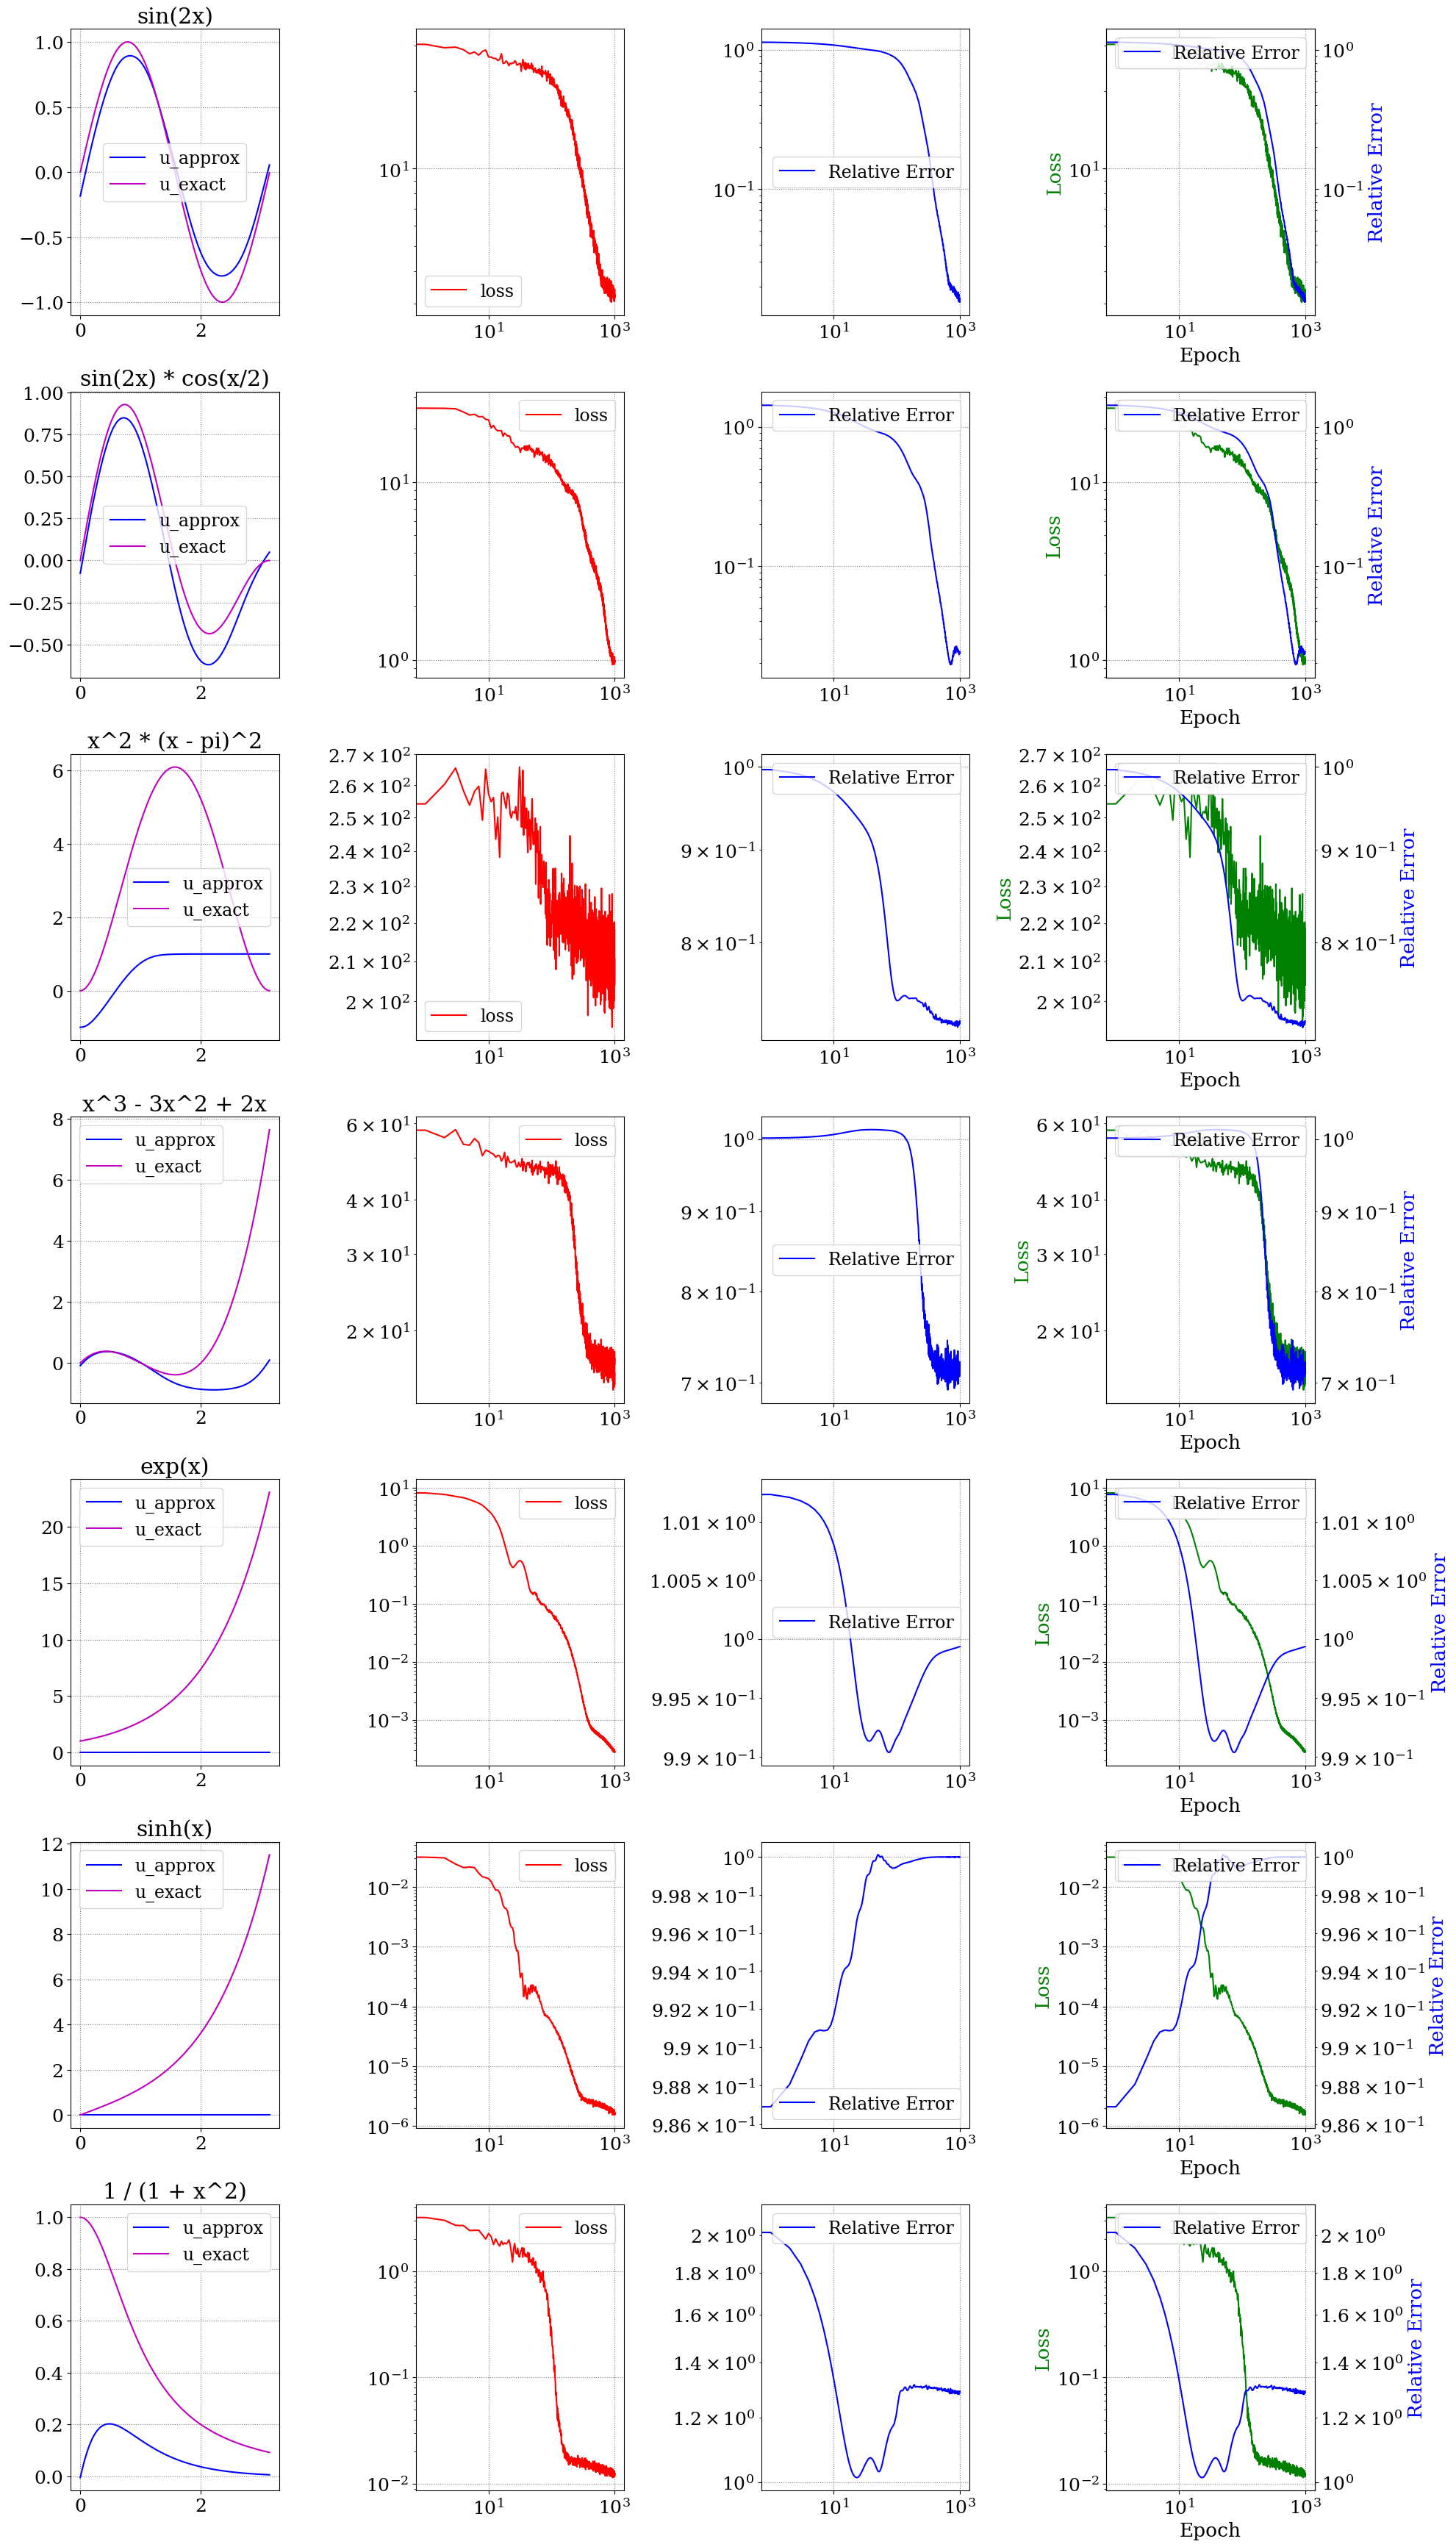

In [55]:
run_experiments_with_different_fRhs(1, 'tanh')

             title  final_loss  final_relative_error
           sin(2x)    1.093766              0.025419
sin(2x) * cos(x/2)    0.419688              0.018281
  x^2 * (x - pi)^2   79.262736              0.403838
   x^3 - 3x^2 + 2x    4.075803              0.582615
            exp(x)    0.000018              0.999981
           sinh(x)    0.000033              0.999917
     1 / (1 + x^2)    0.005901              1.277280


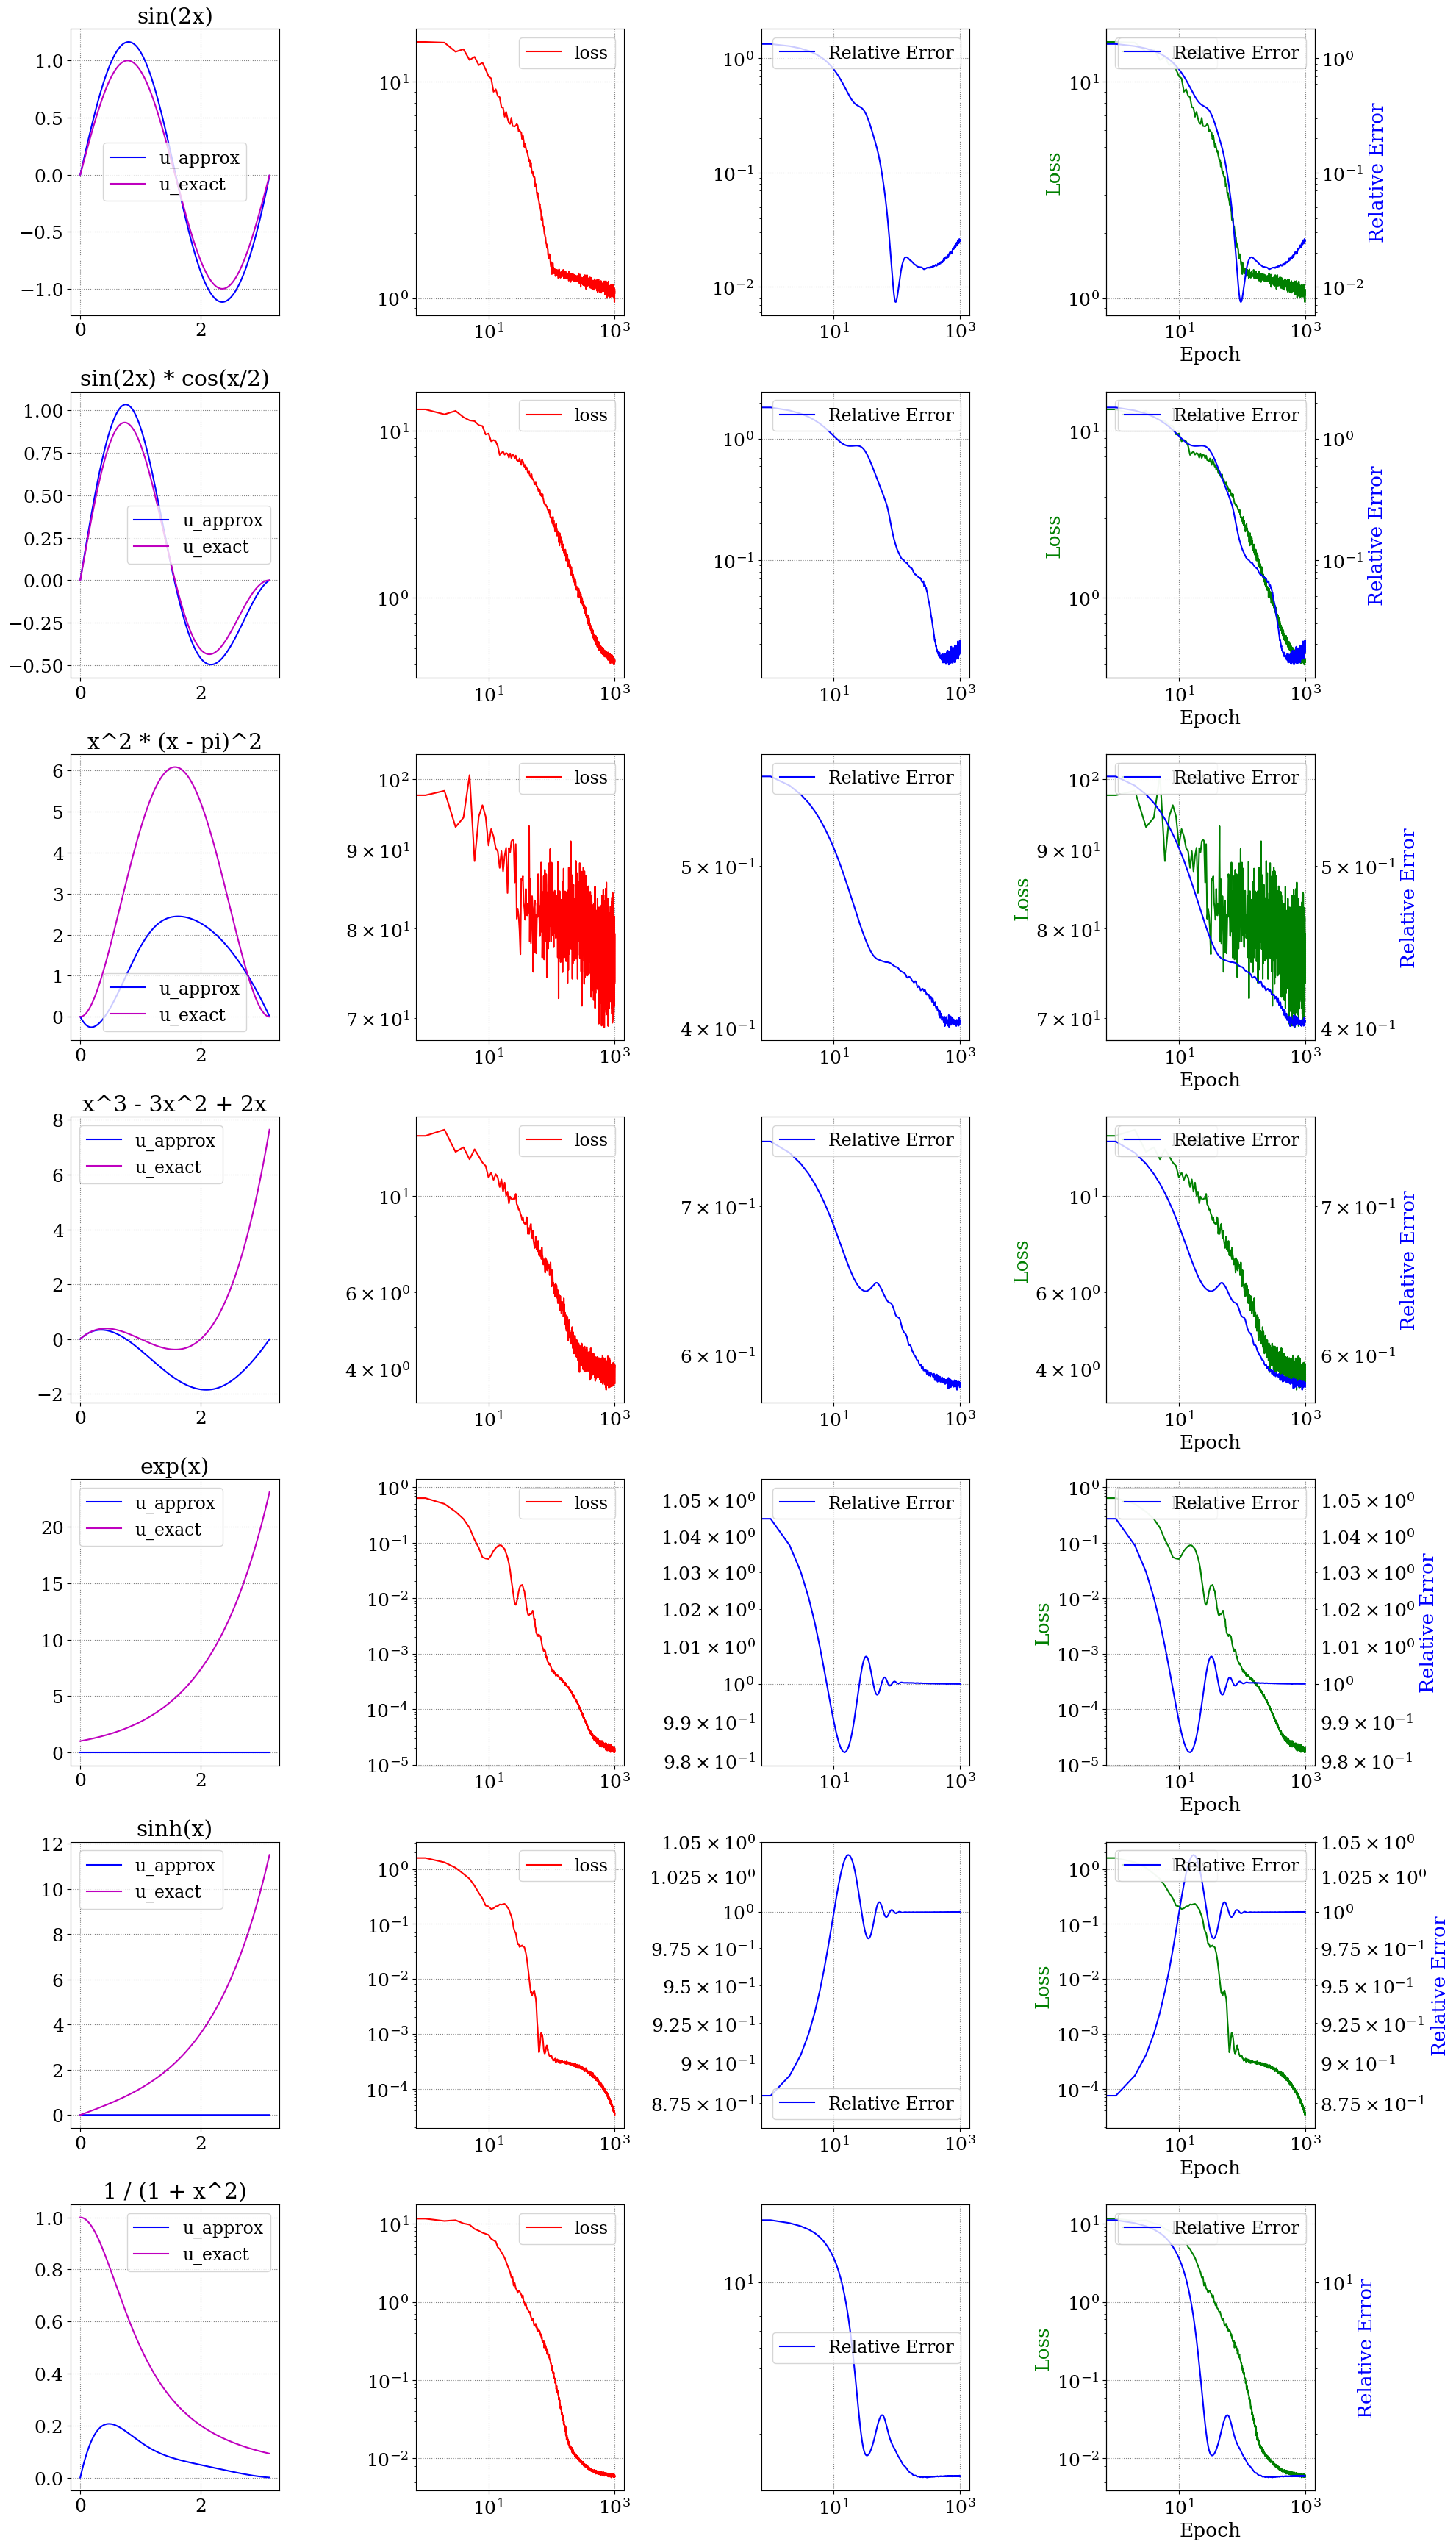

In [59]:
run_experiments_with_different_fRhs(2, 'tanh')